In [4]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax import grad, vmap
import matplotlib.pyplot as plt 
from jax.tree_util import tree_map
from einops import repeat
from utils import gr_than, ls_than

##### 1. Proof that $\frac{dG_1}{d\nabla_{G_0} L_0}$ is not differentiable with `np.where(grads > X)`.

In [5]:
key = random.PRNGKey(23)
key_G0, key_dG0 = random.split(key)

G0  = random.normal(key_G0, (5, 5)) 
dG0 = random.normal(key_dG0, (5, 5)) * 10

def diff_upd_fun(G0, dG0): # supposed to be differentiable wrt dG0 but not.
    G1 = jnp.where(gr_than(dG0, 1.16), 5*G0, G0)
    G1 = jnp.where(ls_than(dG0, -1.16), 5*G0, G1)
    return jnp.sum(G1)

def not_diff_upd_fun(G0, dG0):
    G1 = jnp.where(dG0>1.16, 5*G0, G0)
    G1 = jnp.where(dG0<-1.16, 5*G0, G1)
    return jnp.sum(G1)


G1_nd = not_diff_upd_fun(G0, dG0)
print('This is G1_nd:\n', G1_nd)

G1_d = diff_upd_fun(G0, dG0)
print('-----\nThis is G1_d:\n', G1_d)

grad_diff_upd_fun = grad(diff_upd_fun, argnums=1)
G0_d_grad = grad_diff_upd_fun(G0, dG0)
print('-----\nThis is G0_d_grad:\n', G0_d_grad)

grad_not_diff_upd_fun = grad(not_diff_upd_fun, argnums=1)
G0_nd_grad = grad_not_diff_upd_fun(G0, dG0)
print('-----\nThis is G0_nd_grad:\n', G0_nd_grad)


This is G1_nd:
 24.58363
-----
This is G1_d:
 24.58363
-----
This is G0_d_grad:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
-----
This is G0_nd_grad:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


##### 2. Designing `ls_than()` surrogate function (_won't help Problem #1_)

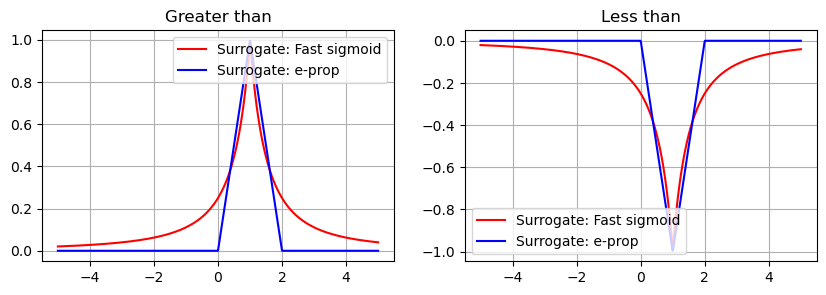

In [6]:
x = jnp.linspace(-5,5,1000)
thr = 1
BETA = 1


plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.title('Greater than')
plt.plot(x, 1/(BETA * jnp.absolute(x - thr) + 1) ** 2, 'red', label='Surrogate: Fast sigmoid')
plt.plot(x, jnp.maximum(jnp.zeros_like(x), 1 - jnp.abs((x-thr)/thr)), 'blue', label='Surrogate: e-prop')
plt.grid(True)
plt.legend()

plt.subplot(122)
plt.title('Less than')
plt.plot(x, -1/(BETA * jnp.absolute(x - thr) + 1) ** 2, 'red', label='Surrogate: Fast sigmoid')
plt.plot(x, jnp.minimum(jnp.zeros_like(x), - 1 + jnp.abs((x-thr)/thr)), 'blue', label='Surrogate: e-prop')
plt.grid(True)
plt.legend()




In [9]:
BETA = 1
THR = 0.01

@jax.custom_jvp
def ls_than(x, thr=THR):
    ''' Less than implementation
    '''
    return (x < thr).astype(jnp.float32)


@ls_than.defjvp
def lt_jvp(primals, tangents):
    ''' Straight-through estimator for lt() operation
    '''
    x, thr = primals
    x_dot, y_dot = tangents
    primal_out = ls_than(x, thr)
    tangent_out = -x_dot / (BETA * jnp.absolute(x - thr) + 1) ** 2
    return primal_out, tangent_out

@jax.custom_jvp
def gr_than(x, thr=THR):
    ''' Heaviside spiking implementation
    '''
    return (x > thr).astype(jnp.float32)


@gr_than.defjvp
def gr_jvp(primals, tangents):
    ''' Straight-through estimator for gt() operation
    '''
    x, thr = primals
    x_dot, y_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot / (BETA * jnp.absolute(x - thr) + 1) ** 2
    return primal_out, tangent_out


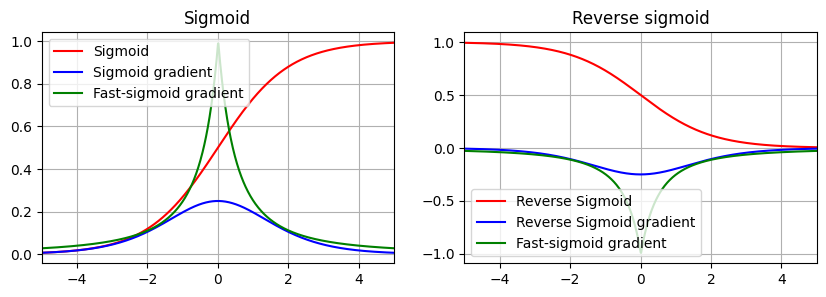

In [10]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.title('Sigmoid')
sigmoid = lambda x: 1/(1 + jnp.exp(-x))
plt.plot(x, sigmoid(x), 'red', label='Sigmoid')
plt.plot(x, vmap(grad(sigmoid))(x), 'blue', label='Sigmoid gradient')
plt.plot(x, vmap(grad(gr_than))(x), 'green', label='Fast-sigmoid gradient')
plt.legend()
plt.xlim([-5,5])
plt.grid()

plt.subplot(122)
plt.title('Reverse sigmoid')
r_sigmoid = lambda x: 1/(1 + jnp.exp(x))
plt.plot(x, r_sigmoid(x), 'red', label='Reverse Sigmoid')
plt.plot(x, vmap(grad(r_sigmoid))(x), 'blue', label='Reverse Sigmoid gradient')
plt.plot(x, vmap(grad(ls_than))(x), 'green', label='Fast-sigmoid gradient')
plt.legend()
plt.xlim([-5,5])
plt.grid()

##### 3. Testing Task Loader

In [7]:
def sample_sinusoid_task(key, batch_size, num_samples_per_task):
    key_A, key_phi, key_s, key_q = random.split(key, 4)
    A_list = random.uniform(key_A, [batch_size], minval=0.1, maxval=5)
    phi_list = random.uniform(key_phi, [batch_size], minval=0, maxval=jnp.pi)
    xS = random.uniform(key_s, [batch_size, num_samples_per_task, 1], minval=-5, maxval=5)
    xQ = random.uniform(key_q, [batch_size, num_samples_per_task, 1], minval=-5, maxval=5)
    
    yS = jnp.zeros((batch_size, num_samples_per_task, 1))
    yQ = jnp.zeros((batch_size, num_samples_per_task, 1))
    for i, (A, phi) in enumerate(zip(A_list, phi_list)):
        yS = yS.at[i].set(A * jnp.sin(xS[i] + phi))
        yQ = yQ.at[i].set(A * jnp.sin(xQ[i] + phi)) 

    xS, yS, xQ, yQ = tree_map(lambda x: repeat(x, 'b n d -> b n t d', t=100), 
                                                  [xS, yS, xQ, yQ])
    return xS, yS, xQ, yQ

xS shape : (8, 100, 100, 1)
xS shape : (8, 100, 100, 1)


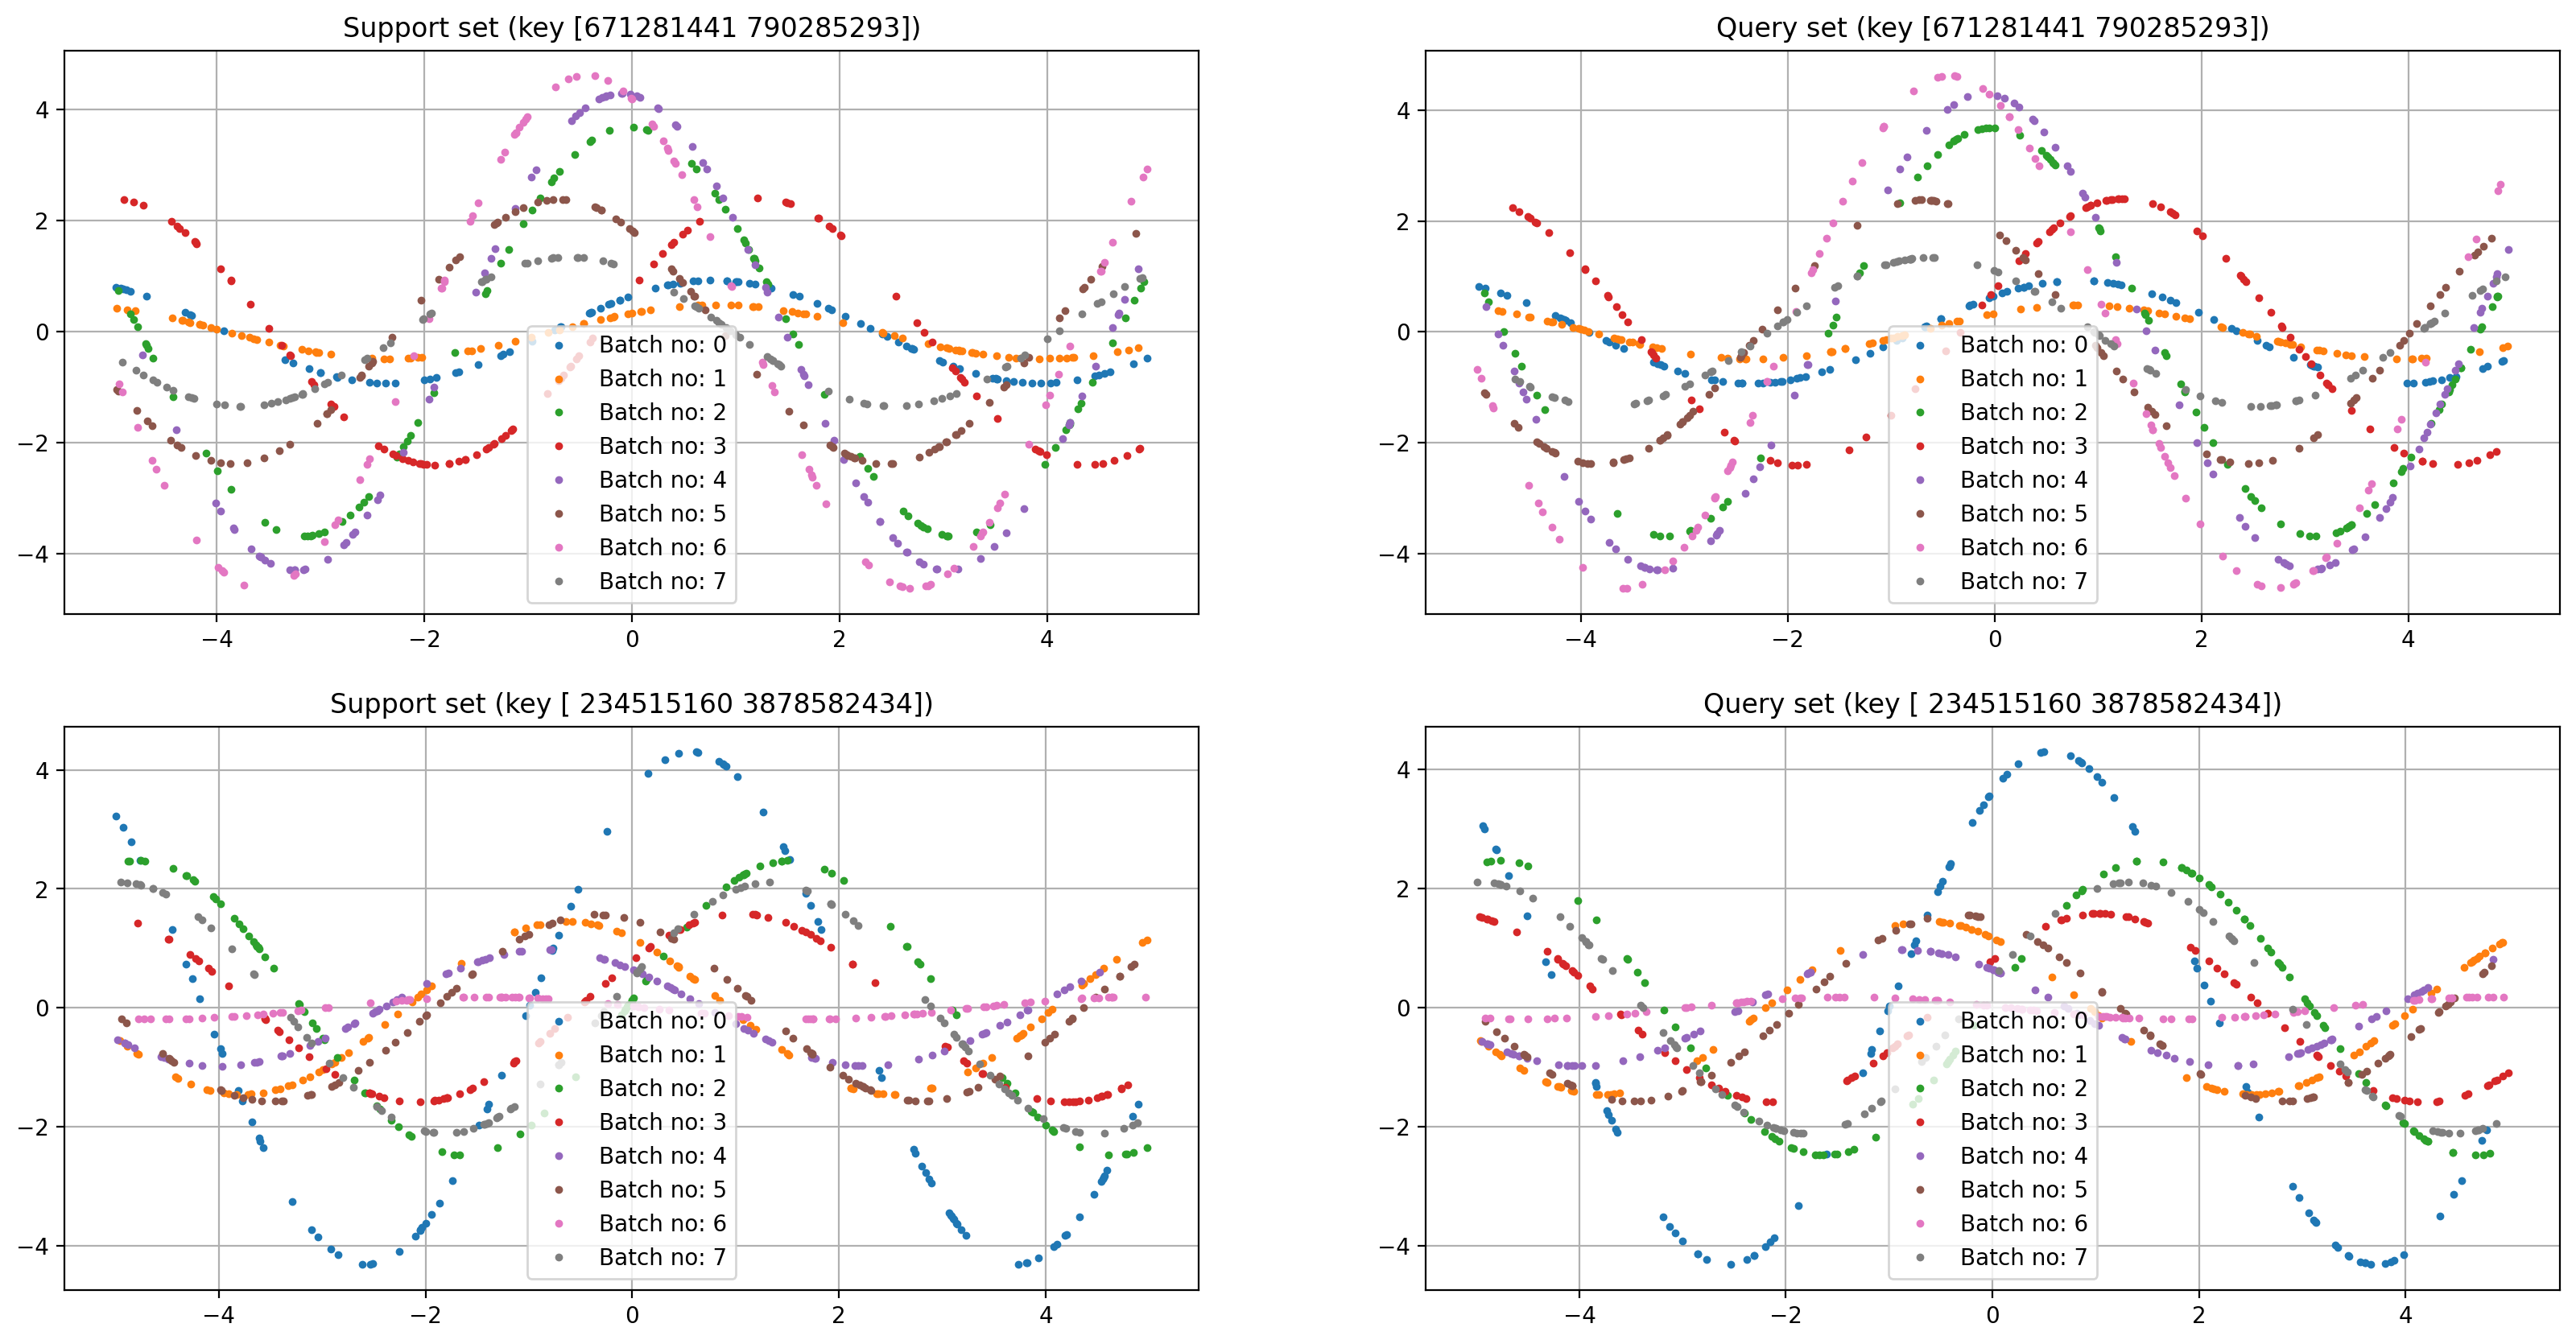

In [84]:
key = random.PRNGKey(33)
batch_size = 8 # Make batch size 64 and compare pi and 2pi phases.
num_samples_per_task = 100

key_train, key_eval = random.split(key, 2)

xS, yS, xQ, yQ = sample_sinusoid_task(key_train, batch_size, num_samples_per_task)
print(f'xS shape : {xS.shape}')

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.title(f'Support set (key {key_train})')
for num_batch in range(batch_size):
    plt.plot(xS[num_batch,:,-1,0], yS[num_batch,:,-1,0], '.', markersize=5, label='Batch no: '+str(num_batch))
    plt.legend()
    plt.grid(True)

plt.subplot(222)
plt.title(f'Query set (key {key_train})')
for num_batch in range(batch_size):
    plt.plot(xQ[num_batch,:,-1,0], yQ[num_batch,:,-1,0], '.', markersize=5, label='Batch no: '+str(num_batch))
    plt.legend()
    plt.grid(True)

xS, yS, xQ, yQ = sample_sinusoid_task(key_eval, batch_size, num_samples_per_task)
print(f'xS shape : {xS.shape}')

plt.subplot(223)
plt.title(f'Support set (key {key_eval})')
for num_batch in range(batch_size):
    plt.plot(xS[num_batch,:,-1,0], yS[num_batch,:,-1,0], '.', markersize=5, label='Batch no: '+str(num_batch))
    plt.legend()
    plt.grid(True)

plt.subplot(224)
plt.title(f'Query set (key {key_eval})')
for num_batch in range(batch_size):
    plt.plot(xQ[num_batch,:,-1,0], yQ[num_batch,:,-1,0], '.', markersize=5, label='Batch no: '+str(num_batch))
    plt.legend()
    plt.grid(True)


In [8]:
def pi2_sample_sinusoid_task(key, batch_size, num_samples_per_task):
    key_A, key_phi, key_s, key_q = random.split(key, 4)
    A_list = random.uniform(key_A, [batch_size], minval=0.1, maxval=5)
    phi_list = random.uniform(key_phi, [batch_size], minval=0, maxval=2*jnp.pi)
    xS = random.uniform(key_s, [batch_size, num_samples_per_task, 1], minval=-5, maxval=5)
    xQ = random.uniform(key_q, [batch_size, num_samples_per_task, 1], minval=-5, maxval=5)
    
    yS = jnp.zeros((batch_size, num_samples_per_task, 1))
    yQ = jnp.zeros((batch_size, num_samples_per_task, 1))
    for i, (A, phi) in enumerate(zip(A_list, phi_list)):
        yS = yS.at[i].set(A * jnp.sin(xS[i] + phi))
        yQ = yQ.at[i].set(A * jnp.sin(xQ[i] + phi)) 

    xS, yS, xQ, yQ = tree_map(lambda x: repeat(x, 'b n d -> b n t d', t=100), 
                                                  [xS, yS, xQ, yQ])
    return xS, yS, xQ, yQ

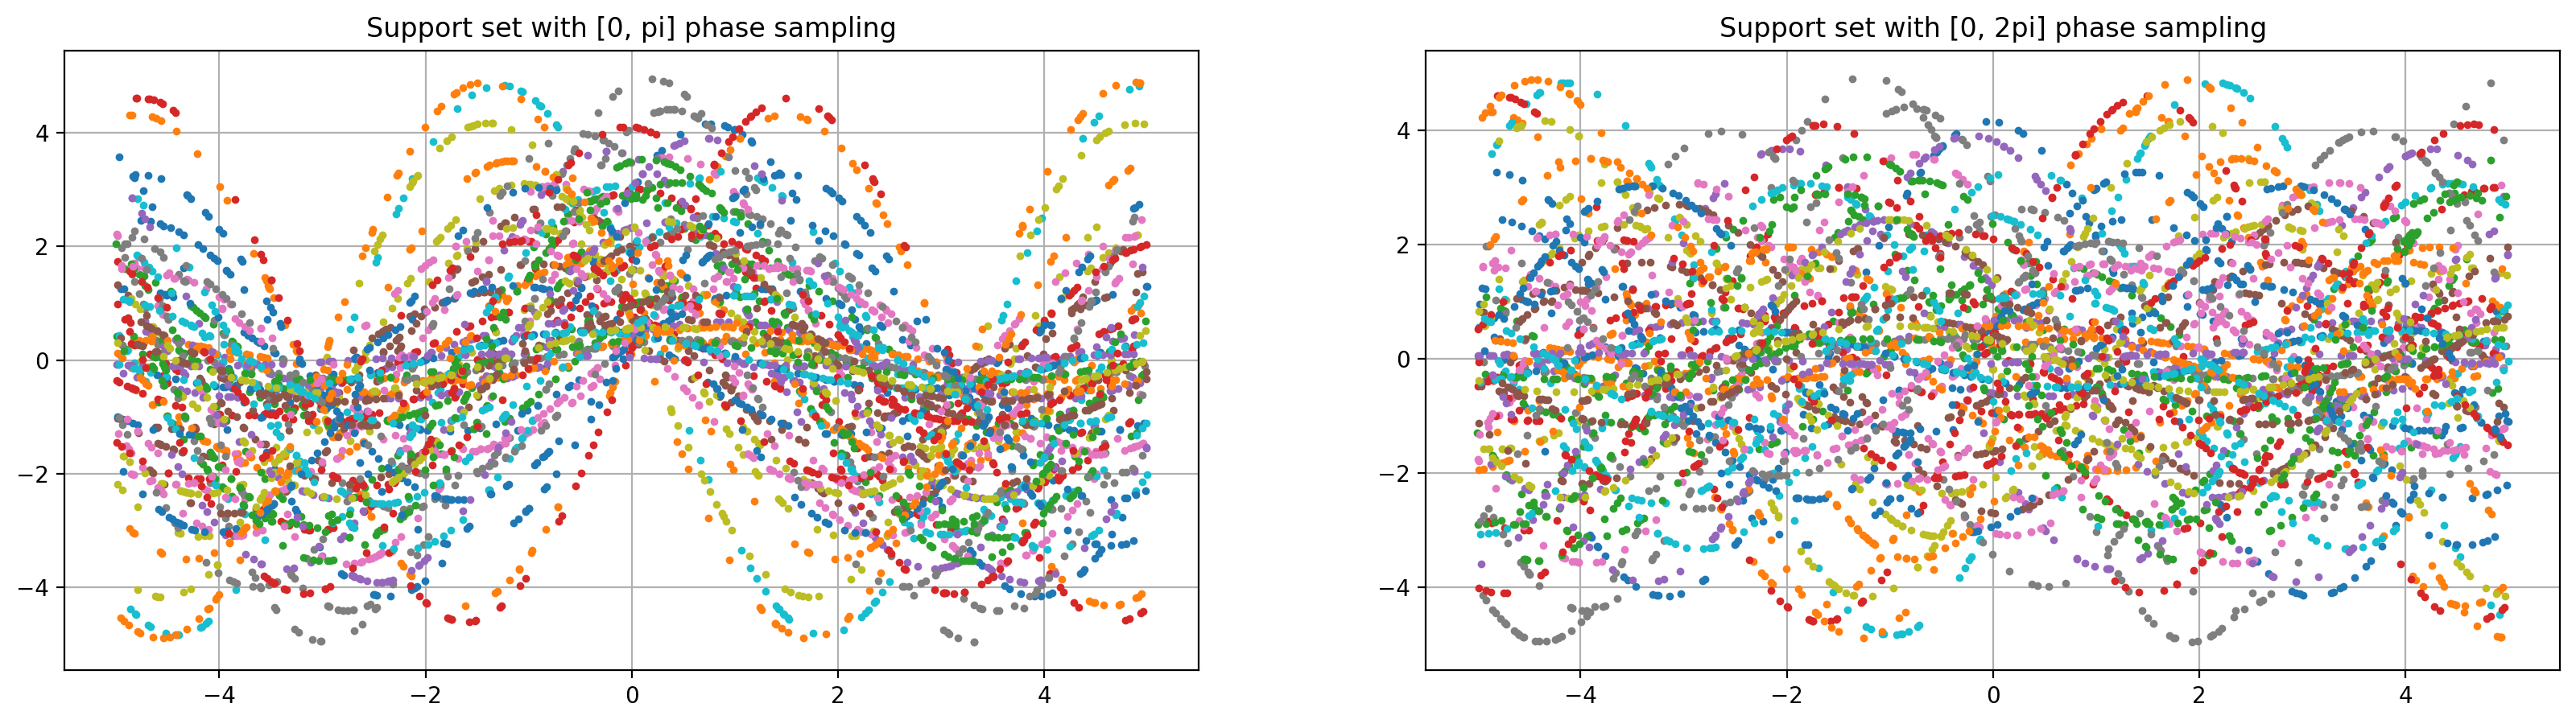

In [86]:
key = random.PRNGKey(33)
batch_size = 64
num_samples_per_task = 100

xS, yS, xQ, yQ = sample_sinusoid_task(key, batch_size, num_samples_per_task)
xS2, yS2, xQ2, yQ2 = pi2_sample_sinusoid_task(key, batch_size, num_samples_per_task)

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title(f'Support set with [0, pi] phase sampling')
for num_batch in range(batch_size):
    plt.plot(xS[num_batch,:,-1,0], yS[num_batch,:,-1,0], '.', markersize=5, label='Batch no: '+str(num_batch))
    plt.grid(True)

plt.subplot(122)
plt.title(f'Support set with [0, 2pi] phase sampling')
for num_batch in range(batch_size):
    plt.plot(xS2[num_batch,:,-1,0], yS2[num_batch,:,-1,0], '.', markersize=5, label='Batch no: '+str(num_batch))
    plt.grid(True)

##### 4. Output layer update via tree_map

In [9]:
a = [[2,3], [1,1,4], [4,2,1,0]]
filter_list = [[0, 0], [1, 0, 0], [1, 1, 1, 1]]

def filter(pytree, filter_pytree, function):
    return tree_map(lambda x, y: function(x) if y else x, pytree, filter_pytree)

filter(a, filter_list, lambda x: 0)

[[2, 3], [0, 1, 4], [0, 0, 0, 0]]